# Discrete Memristor Networks

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve, cg
import numpy.random
import generate_adjacency_matrix as gen_adj
import resistor_networks_basic as rnets
from matplotlib.patches import ConnectionPatch

import itertools

from __future__ import division

In [3]:
import matplotlib.pyplot as plt

In [4]:
class DiscreteMemRNetwork(rnets.ResistorNetwork):
    """
    This class inherits from ResistorNetwork with the aim of adding some dynamical behavior to the
    resistors.  In particular, when a resistor has past a certain current threshold, the conductance
    is increased/decreased by an increment (G_Final - G_Initial / N):
    
        G                     - An NxN sparse CSR matrix containing the conductances in the network of N nodes
        external_voltages     - An Nx1 dense vector of external voltages.  Nodes not set to an external voltages
                                contain a Nan. The shape (N,) is preferred
        I_threshold           - A sparse array of thresholds for each memristor
        G_Initial             - The initial conductance of the network elements.
        G_Final               - The final conductance of the network elements.
        N_states              - The number of internal states available to the memristor that is by default 2
    
    Other available attributes after initialization are:
        currents              - An NxN sparse matrix of currents in the network.  As many tasks in the network will
                                require that the currents be calculated, it is best that we do this once and share.
        rows_G
        cols_G
    """
    
    def __init__(self, G, external_voltages, I_threshold, G_Initial=1, G_Final=100, N_states=2):
        rnets.ResistorNetwork.__init__(self, G, external_voltages)
        self.I_threshold = I_threshold
        self.G_Initial = G_Initial
        self.G_Final = G_Final
        self.N_states = N_states
        self.G_step = (self.G_Final - self.G_Initial) / (self.N_states - 1)
        self.rows_G, self.cols_G = sparse.triu(self.G).nonzero()
        self.currents = None
            
    def calculate_currents(self):
        """
        calculates a matrix of currents running through each memristor.  Only the upper triangular portion
        of the matrix is calculated.
        """
        self.currents = sparse.lil_matrix(self.G.shape, dtype=float)
        self.currents[self.rows_G, self.cols_G] = np.multiply(self.G[self.rows_G, self.cols_G],
                                                  np.abs(self.voltages[self.rows_G] - self.voltages[self.cols_G]))
        self.currents = self.currents + self.currents.T
    
    def next_switching_factor(self):
        """
        Find the factor necessary to adjust the voltage to switch the next memristor
        """
        if self.G_Initial < self.G_Final:
            temp, idx = np.multiply(self.G[self.rows_G, self.cols_G] >= self.G_Initial,
                                    self.G[self.rows_G, self.cols_G] <  self.G_Final).nonzero()
        elif self.G_Initial > self.G_Final:
            temp, idx = np.multiply(self.G[self.rows_G, self.cols_G] <= self.G_Initial,
                                    self.G[self.rows_G, self.cols_G] >  self.G_Final).nonzero()
        rows, cols = self.rows_G[idx], self.cols_G[idx]
        return np.min(np.divide(self.I_threshold[rows, cols], self.currents[rows, cols]))
        
    def switch_memristors(self):
        """
        Check the currents on each memristor.  Those that have not reached G_Final and whose currents are greater
        than their thresholds will have their conductance incremented
        """
        current_mask = self.currents[self.rows_G, self.cols_G] > self.I_threshold[self.rows_G, self.cols_G]
        if self.G_Initial < self.G_Final:
            memristor_mask = np.multiply(self.G[self.rows_G, self.cols_G] >= self.G_Initial,
                                    self.G[self.rows_G, self.cols_G] <  self.G_Final)
        elif self.G_Initial > self.G_Final:
            memristor_mask = np.multiply(self.G[self.rows_G, self.cols_G] <= self.G_Initial,
                                    self.G[self.rows_G, self.cols_G] >  self.G_Final)
        temp, switching_idx = np.multiply(current_mask, memristor_mask).nonzero()
        switching_rows, switching_cols = self.rows_G[switching_idx], self.cols_G[switching_idx]
        
        #Increment memristors that will satisfy the criteria
        if switching_rows.size == 0:
            return 0
        else:
            self.G[switching_rows, switching_cols] += self.G_step
            self.G[switching_cols, switching_rows] += self.G_step
            # To be safe, we need to ensure that anything that may have slipped the bounds due to numerical
            # differences is put back in order.
            if self.G_Final > self.G_Initial:
                self.G[self.G > self.G_Final] = self.G_Final
            elif self.G_Final < self.G_Initial:
                self.G.data[self.G.data < self.G_Final] = self.G_Final
            return switching_rows.size 

    def switching_step(self):
        counter = []
        self.solve_voltages('spsolve')
        self.calculate_currents()
        num_switched = self.switch_memristors()
        while num_switched != 0:
            counter.append(num_switched)
            self.solve_voltages('spsolve')
            self.calculate_currents()
            num_switched = self.switch_memristors()
        return counter
    
    def new_voltage(self, prev_voltage):
        return prev_voltage * (self.next_switching_factor() + 1e-10)

    def update_voltage_busbar(self, voltage):
        """
        Using bus bar topology, this takes the previous voltage at the zeroth node and updates it so that the next memristor
        will flip
        """
        self.external_voltages[0:int(np.sqrt(self.G.shape[0]))] = voltage
        
    def display_diag_grid(self, ax, lattice_shape, display_variable, nodesize=5, bondwidth=3, colormin=None, colormax=None,
                     colormap_name=None):
        
        def node2xy(node_idx):
            """
            returns the x and y coordinates of a node index in our grid supposing that the 0,0 point is in the upper left
            and the positive y-axis points down
            """
            col_index = node_idx % lattice_shape[1]
            row_index = node_idx // lattice_shape[1]
            row_parity = row_index % 2
            
            return col_index + (0.5 * row_parity), 0.5 * row_index
        
        
        # Pull nonzero values to plot bonds
        rows, cols = sparse.triu(self.G).nonzero()
        
        
        # Set up colormap normalization
        
        if colormin != None:
            norm = plt.Normalize(vmin=colormin, vmax=colormax)
        elif display_variable == 'voltage':
            norm = plt.Normalize()
            norm.autoscale(self.voltages)
        elif display_variable == 'power':
            power = self.power()
            norm = plt.Normalize(vmin=power.min(), vmax=power.max())
        elif display_variable == 'conductance':
            # I'd like the OFF grey to be lighter than the minimum of the color map
            # so I'm setting it so that it falls 1/3 through the colormap
            mincond = min(self.G_Initial, self.G_Final)
            maxcond = max(self.G_Initial, self.G_Final)
            if self.G_Final > self.G_Initial:
                low_colormap = maxcond - 1.5 * (maxcond-mincond)
                norm = plt.Normalize(vmin=low_colormap, vmax=maxcond)
            else:
                high_colormap = mincond + 1.5 * (maxcond - mincond)
                norm = plt.Normalize(vmin=mincond, vmax=high_colormap)
        elif display_variable == 'voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=0, vmax=voltage_drop.max())
        elif display_variable == 'log_voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=np.log(voltage_drop.data.min()),
                                 vmax=np.log(voltage_drop.max()))
        
        if colormap_name != None:
            colormap = plt.get_cmap(colormap_name)
        else:
            if display_variable == 'voltage':
                colormap = plt.get_cmap('Reds')
            elif display_variable == 'power':
                colormap = plt.get_cmap('YlOrRd')
            elif display_variable == 'conductance':
                if self.G_Final > self.G_Initial:
                    colormap = plt.get_cmap('RdGy_r')
                else:
                    colormap = plt.get_cmap('RdGy')
            elif display_variable == 'voltage_drop':
                colormap = plt.get_cmap('jet')
            elif display_variable == 'log_voltage_drop':
                colormap = plt.get_cmap('jet')
        
        # Draw the bonds between nodes
        for node_i, node_j in itertools.izip(rows, cols):
            x_i, y_i = node2xy(node_i)
            x_j, y_j = node2xy(node_j)
            #Check for our wrap around nodes
            if node_j - node_i == 2*lattice_shape[1] - 1:
                x_i = x_i + lattice_shape[1]
            elif node_j - node_i == 1:
                x_j = x_j + lattice_shape[1]
            
            if display_variable == 'voltage':
                ax.plot([x_i, x_j], [y_i, y_j], 'k', lw = bondwidth)
            elif display_variable == 'power':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(power[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'conductance':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(self.G[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(voltage_drop[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'log_voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(np.log(voltage_drop[node_i, node_j]))), lw=bondwidth)
                
        # Now draw the nodes
        if display_variable == 'voltage':
            for node, volt in enumerate(self.voltages):
                x, y = node2xy(node)
                ax.plot(x, y, 's', markersize=nodesize, color=colormap(norm(volt)))
        elif display_variable == 'power' or 'conductance' or 'voltage_drop' or 'log_voltage_drop':
            for node in range(self.nodes):
                x, y = node2xy(node)
                ax.plot(x, y, 'ws', markersize=nodesize)
        
        # And finally set the axes to be just outside the grid spacing and invert the y_axis
        ax.set_xlim( -1, lattice_shape[1]+1)
        ax.set_ylim( -1, 0.5 * (lattice_shape[0]+1))
        ax.invert_yaxis()
        ax.xaxis.set_tick_params(labelbottom='off', labeltop='on')

In [6]:
G_ON = 100
G_OFF = 1
L = 16

In [7]:
L_x = L
L_y = 2 * L_x + 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x)) * G_OFF

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0.1, high=1, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / G_OFF + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = DiscreteMemRNetwork(G, external_voltages, I_threshold=I_threshold, G_Initial=G_OFF, G_Final=G_ON, N_states=10)

test.solve_voltages('spsolve')
test.calculate_currents()

test.solve_voltages('spsolve')
test.calculate_currents()

counter = 0
total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter  = (test.G == test.G_Final).nnz / 2
conductivities.append(test.conductivity())

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter  = (test.G == test.G_Final).nnz / 2
    conductivities.append(test.conductivity())
    
voltages_OFF2ONlist = []
conductivities_OFF2ONlist = []
for n, v in enumerate(voltages):
    voltages_OFF2ONlist.extend([v, v])
    conductivities_OFF2ONlist.extend([conductivities[n], conductivities[n+1]])
    
voltages_OFF2ON = np.asarray(voltages_OFF2ONlist)
conductivities_OFF2ON = np.asarray(conductivities_OFF2ONlist)

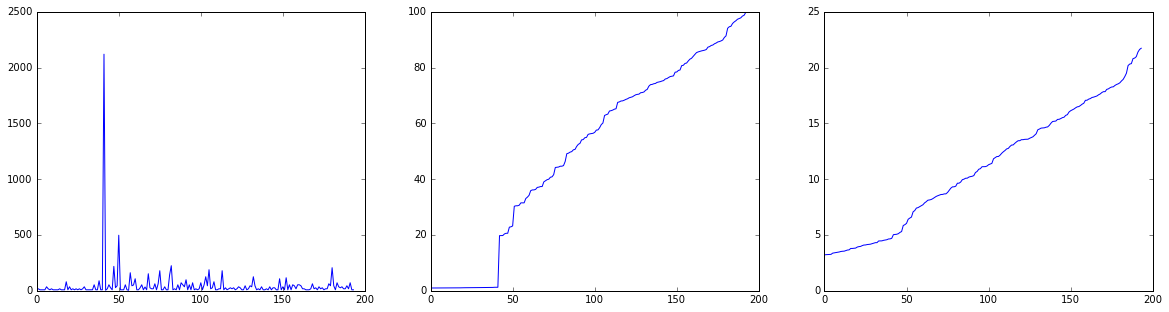

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

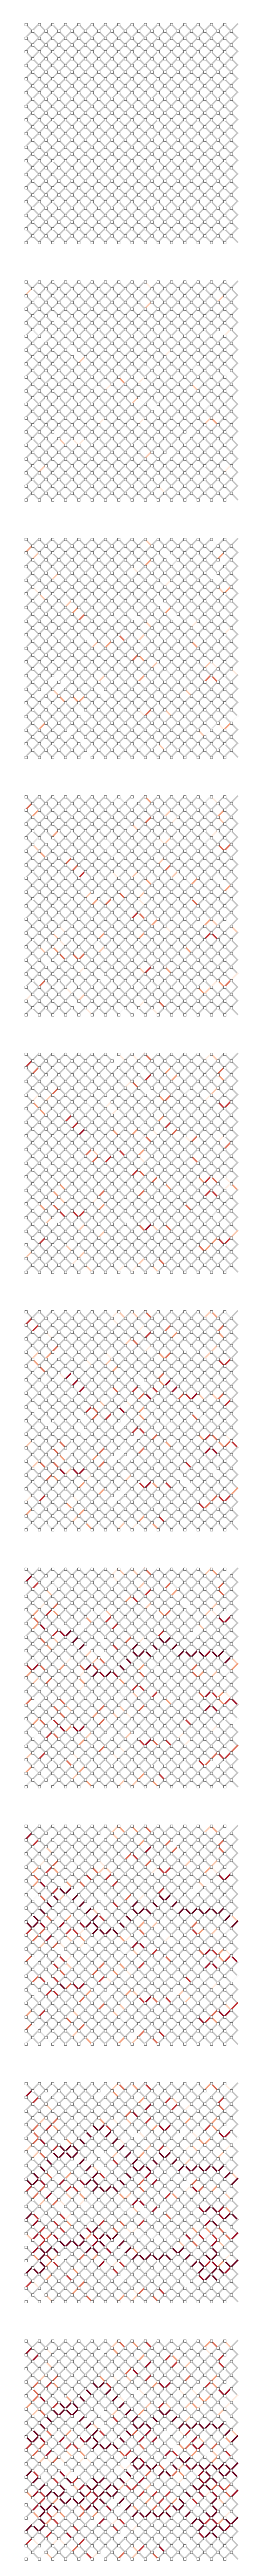

In [10]:
L_x = L
L_y = 2 * L_x + 1


fig, ax = plt.subplots(10, 1, figsize=(7, 70))

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x)) * G_ON

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0.1, high=1, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / G_ON + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = DiscreteMemRNetwork(G, external_voltages, I_threshold=I_threshold, G_Initial=G_ON, G_Final=G_OFF, N_states=10)


test.solve_voltages('spsolve')
test.calculate_currents()

test.display_diag_grid(ax[0], (L_y, L_x), 'conductance')
ax[0].set_axis_off()

counter = 0
total_memristors = 2 * L_x * (L_y-1)

event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter  = (test.G == test.G_Final).nnz / 2
conductivities.append(test.conductivity())

step = 1
step_idx = 100
if step % step_idx == 0:
    if step // step_idx < 10:
        test.display_diag_grid(ax[step // step_idx], (L_y, L_x), 'conductance')
        ax[step // step_idx].set_axis_off()
#print counter / total_memristors
    
while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter  = (test.G == test.G_Final).nnz / 2
    conductivities.append(test.conductivity())
    step += 1
    if step % step_idx == 0:
        if step // step_idx < 10:
            test.display_diag_grid(ax[step // step_idx], (L_y, L_x), 'conductance')
            ax[step // step_idx].set_axis_off()
    #print counter / total_memristors
    
plt.tight_layout()


voltages_ON2OFFlist = []
conductivities_ON2OFFlist = []
for n, v in enumerate(voltages):
    voltages_ON2OFFlist.extend([v, v])
    conductivities_ON2OFFlist.extend([conductivities[n], conductivities[n+1]])
    
voltages_ON2OFF = np.asarray(voltages_ON2OFFlist)
conductivities_ON2OFF = np.asarray(conductivities_ON2OFFlist)

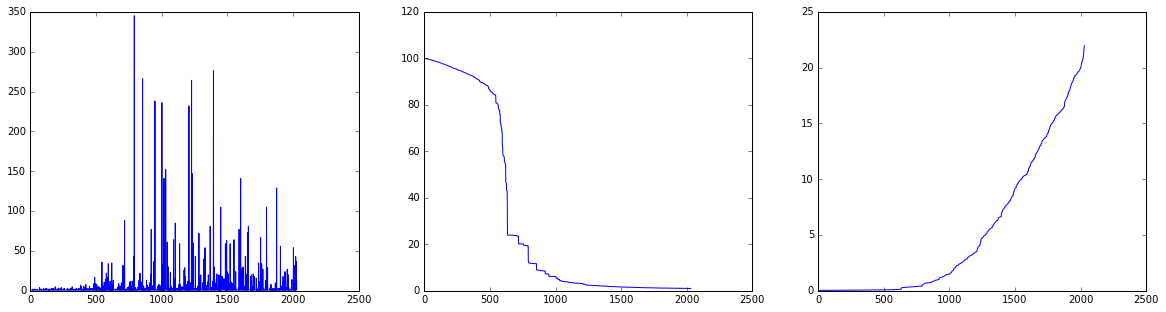

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

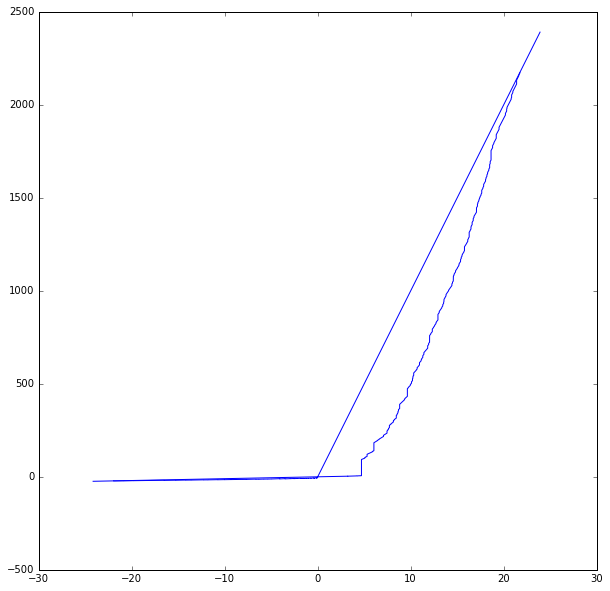

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
g_ON = G_ON
g_OFF = G_OFF

G_ON = g_ON / ( L_y - 1) * 2 * L_x

G_OFF = g_OFF / ( L_y - 1) * 2 * L_x


ax.plot([0, voltages_OFF2ON[0]], [0, conductivities_OFF2ON[0]*voltages_OFF2ON[0]])
ax.plot(voltages_OFF2ON, conductivities_OFF2ON*voltages_OFF2ON, c='b')
ax.plot([0, 1.1*voltages_OFF2ON[-1]],  [0, G_ON * 1.1*voltages_OFF2ON[-1]], c='b')
ax.plot([0, -1*voltages_ON2OFF[0]], [0, -1*conductivities_ON2OFF[0]*voltages_ON2OFF[0]], c='b')
ax.plot(-1*voltages_ON2OFF, -1*conductivities_ON2OFF*voltages_ON2OFF, c='b')
ax.plot([0, -1.1*voltages_ON2OFF[-1]],  [0, G_OFF *-1.1*voltages_ON2OFF[-1]], c='b')
#ax.set_ylim(-75, 0)